In [8]:
import scanpy as sc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

def preprocess_data(path, n_pcs=20):
    # Load data    
    data = sc.read_10x_mtx(path, gex_only=True)
    # Filter cells and genes
    sc.pp.filter_cells(data, min_genes=200)
    sc.pp.filter_genes(data, min_cells=3)
    
    # Calculate QC metrics
    mito_genes = data.var_names.str.startswith('MT-')
    data.obs['percent_mito'] = data[:, mito_genes].X.sum(axis=1) / data.X.sum(axis=1) * 100
    data = data[data.obs['percent_mito'] < 10, :]  

    # Normalize and log transform
    sc.pp.normalize_total(data)
    sc.pp.log1p(data)
    data.raw = data
    
        
    # Identify variable genes
    sc.pp.highly_variable_genes(data)

    # PCA 

    # Z-score scale. Clip values exceeding standard deviation 10.
    sc.pp.scale(data, max_value=10)

    # PCA, default subsets to highly variable features
    sc.tl.pca(data)

    # A visualization that is useful for determining how many PCs to include
    sc.pl.pca_variance_ratio(data, n_pcs=20)
    
    # computing the neighborhood graph and find clusters
    sc.pp.neighbors(data, n_pcs=20)
    sc.tl.leiden(data, resolution=0.3)
    sc.tl.umap(data)                 
        
    return data

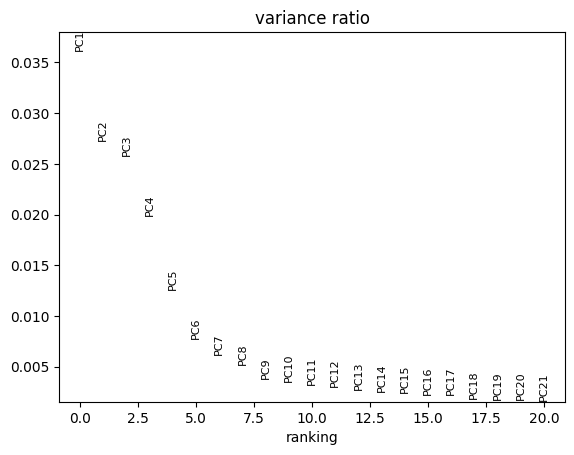

In [9]:
chung = preprocess_data('Chung', n_pcs=20)

"adding metadata to anndata object provided from GEO"
import pandas as pd
# Load the metadata from CSV
metadata_df = pd.read_csv("Chung/metadata.csv", skiprows=[1])

# Convert the metadata to a dictionary
metadata_dict = metadata_df.to_dict('list')

# Add metadata to AnnData object
for key in metadata_dict:
    chung.obs[key] = metadata_dict[key]

In [10]:
chung

AnnData object with n_obs × n_vars = 33206 × 16621
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'NAME', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'cell_type', 'cell_type__ontology_label', 'cell_type_detail'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

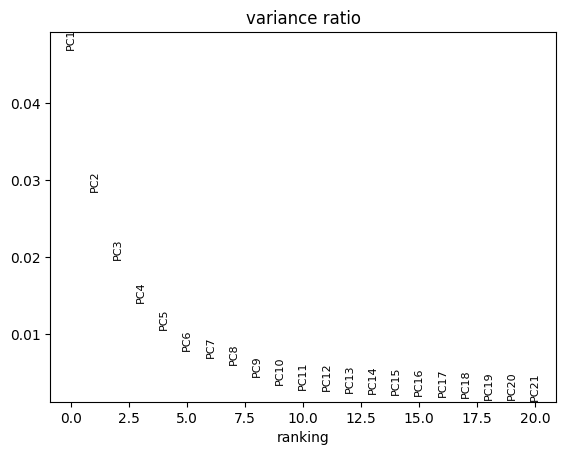

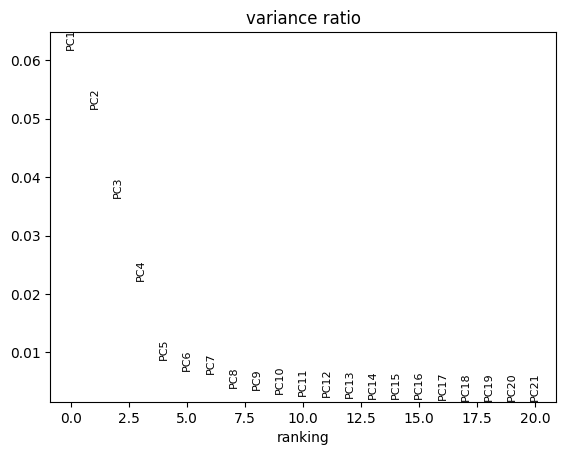

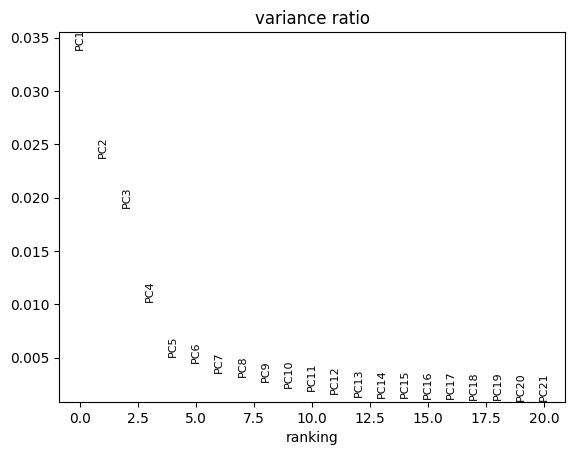

In [11]:
townsend_JLE48_3 = preprocess_data('Townsend_JLE48_3', n_pcs=20)
townsend_JLE49_3 = preprocess_data('Townsend_JLE49_3', n_pcs=20)
townsend_JLE50_3 = preprocess_data('Townsend_JLE50_3', n_pcs=20)

In [12]:
townsend_JLE48_3

AnnData object with n_obs × n_vars = 6729 × 30341
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

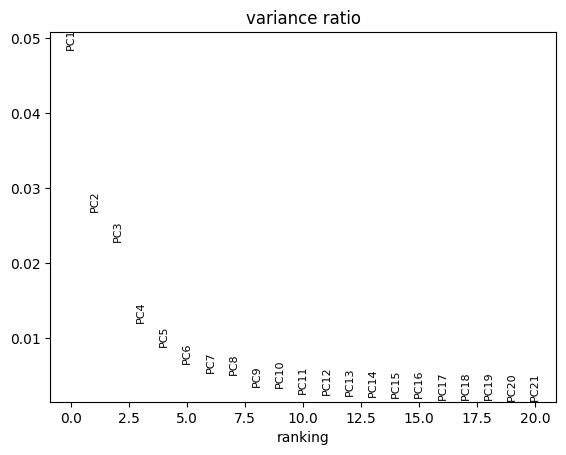

FileNotFoundError: Did not find file Westfall_JLE33/matrix.mtx.gz.

In [13]:
westfall_JLE18 = preprocess_data('Westfall_JLE18', n_pcs=20)


In [14]:
westfall_JLE18

AnnData object with n_obs × n_vars = 3811 × 29934
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

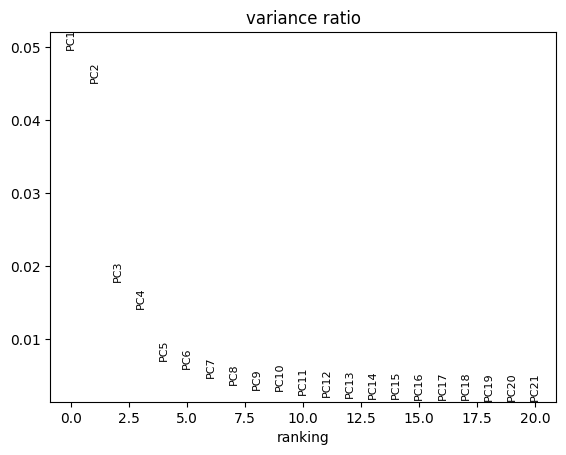

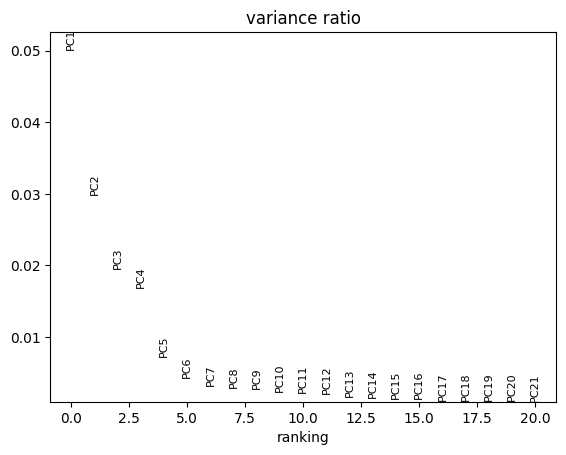

FileNotFoundError: Did not find file Westfall_NB4337/matrix.mtx.gz.

In [15]:
westfall_JLE33 = preprocess_data('Westfall_JLE33', n_pcs=20)
westfall_NB1499 = preprocess_data('Westfall_NB1499', n_pcs=20)

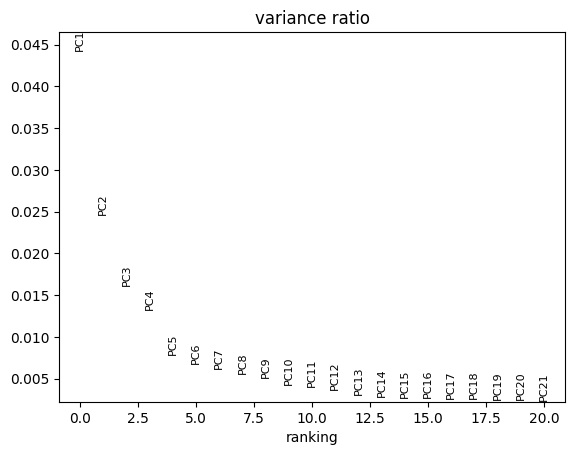

In [16]:
westfall_NB4327 = preprocess_data('Westfall_NB4327', n_pcs=20)

In [33]:
ref_data = chung 

In [34]:
# compare genes in both reference and unannotated sample
def transfer_annotations(unannotated, reference):
    var_names = reference.var_names.intersection(unannotated.var_names)
    unannotated = unannotated[:, var_names]
    reference = reference[:, var_names]
    sc.tl.ingest(unannotated, reference, obs='cell_type_detail')
    return unannotated
    

In [41]:
townsend_JLE48_3 = transfer_annotations(townsend_JLE48_3, ref_data)
townsend_JLE49_3 = transfer_annotations(townsend_JLE49_3, ref_data)
townsend_JLE50_3 = transfer_annotations(townsend_JLE50_3, ref_data)

In [45]:
westfall_JLE18 = transfer_annotations(westfall_JLE18, ref_data)
westfall_JLE33 = transfer_annotations(westfall_JLE33, ref_data)
westfall_NB1499 = transfer_annotations(westfall_NB1499, ref_data)
westfall_NB4327 = transfer_annotations(westfall_NB4327, ref_data)

In [50]:
chung_CTRL8352 = ref_data[ref_data.obs['biosample_id'] == 'CTRL8352', :]
chung_CTRL8353 = ref_data[ref_data.obs['biosample_id'] == 'CTRL8353', :]
chung_FCD4512 = ref_data[ref_data.obs['biosample_id'] == 'FCD4512', :]

/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/site-packages/scanpy/plot

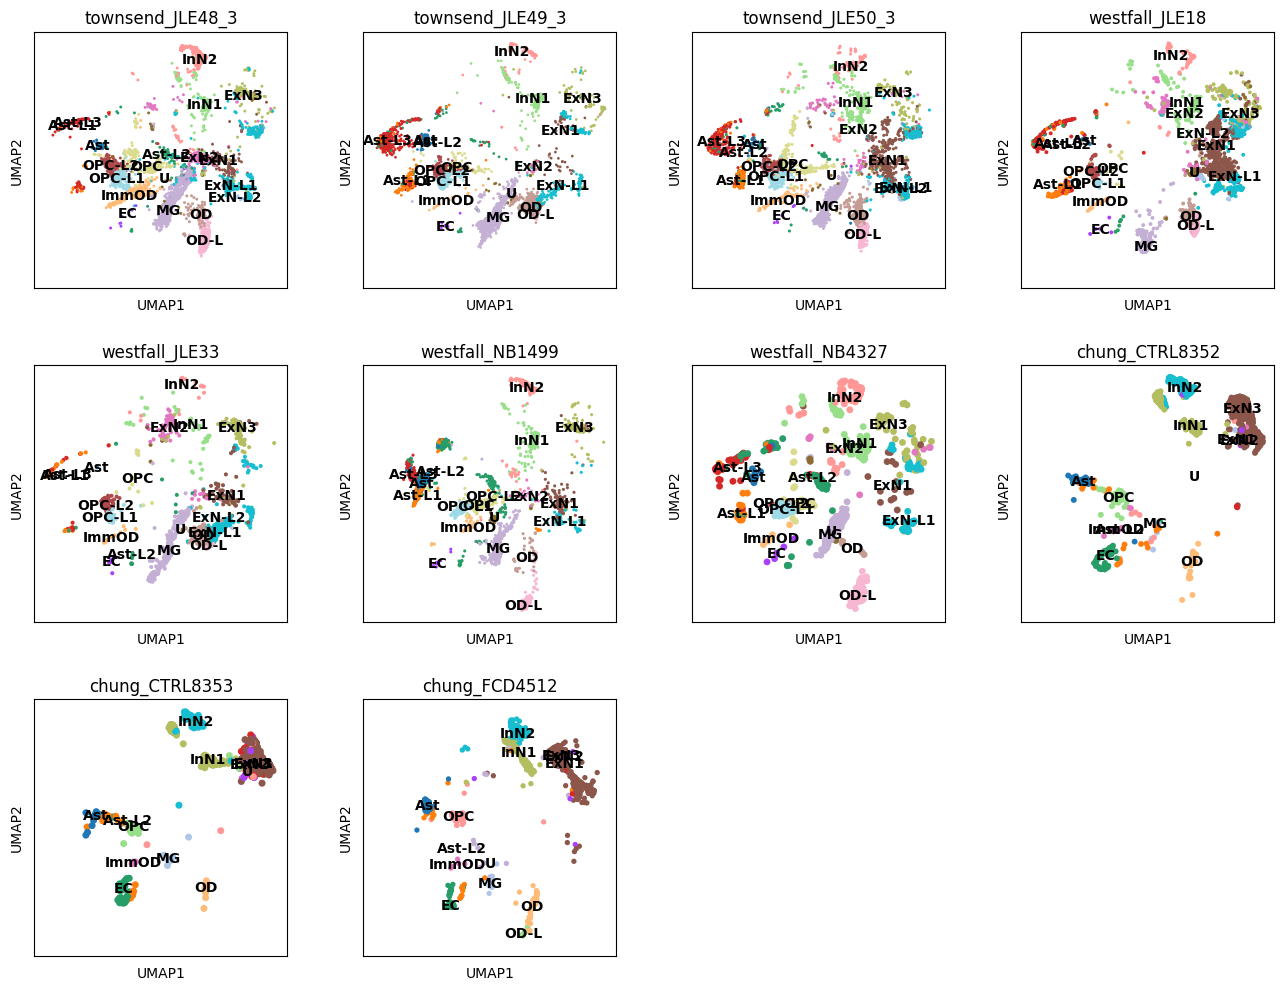

In [73]:
import math
# Load your 8 preprocessed, annotated, and clustered AnnData objects into a list
adatas = [townsend_JLE48_3, townsend_JLE49_3, townsend_JLE50_3,
         westfall_JLE18,westfall_JLE33,westfall_NB1499, westfall_NB4327,
         chung_CTRL8352,chung_CTRL8353,chung_FCD4512]

adatas_titles = ["townsend_JLE48_3", "townsend_JLE49_3", "townsend_JLE50_3",         "westfall_JLE18", "westfall_JLE33", "westfall_NB1499", "westfall_NB4327",         "chung_CTRL8352", "chung_CTRL8353", "chung_FCD4512"]

n_plots = len(adatas)
n_rows = int(math.sqrt(n_plots))
n_cols = int(math.ceil(n_plots / n_rows))

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)

# Flatten the axs array to allow for iteration over each axis
axs = axs.flatten()

# Loop through each AnnData object and create a UMAP plot in the corresponding subplot
for i, adata in enumerate(adatas):
    ax = axs[i]
    sc.pl.umap(adata, color=['cell_type_detail'], legend_loc='on data',ax=ax, show=False)
    ax.set_title(f"{adatas_titles[i]}")
# Remove any unused subplots
for ax in axs[n_plots:]:
    ax.remove()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()

/usr/local/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


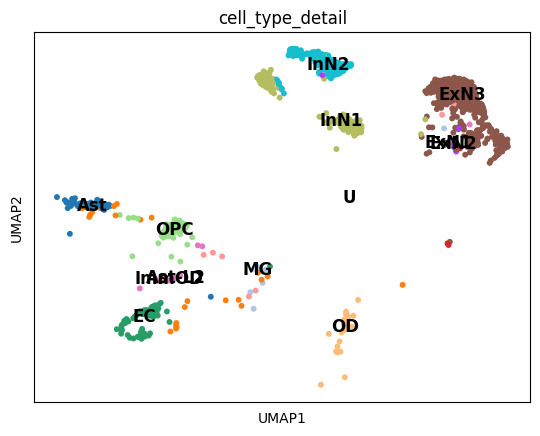

In [39]:
subset_data = ref_data[ref_data.obs['biosample_id'] == 'CTRL8352', :]
sc.pl.umap(subset_data, color=['cell_type_detail'], legend_fontsize=12, legend_loc='on data')
plt.show()

In [80]:
westfall_NB1499.write_h5ad('Annotated/westfall_NB1499')


"""[townsend_JLE48_3, townsend_JLE49_3, townsend_JLE50_3,
         westfall_JLE18,westfall_JLE33,westfall_NB1499, westfall_NB4327,
         chung_CTRL8352,chung_CTRL8353,chung_FCD4512]"""

'[townsend_JLE48_3, townsend_JLE49_3, townsend_JLE50_3,\n         westfall_JLE18,westfall_JLE33,westfall_NB1499, westfall_NB4327,\n         chung_CTRL8352,chung_CTRL8353,chung_FCD4512]'

In [ ]:
# how to save files
#chung.write_h5ad('chung.h5ad')